In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Fonction pour lire les données de transcription
def read_transcription(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# Fonction pour lire les données du graphe de discours
def read_discourse_graph(file_path):
    with open(file_path, 'r') as file:
        data = [line.strip().split() for line in file]

    # Convertir les valeurs non numériques en indices numériques
    data = [(int(start), relation, int(end)) if start.isdigit() and end.isdigit() else (start, relation, end) for start, relation, end in data]

    return data

def create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict):
    rows = []

      # Iterate through all edges in the discourse graph
    for edge in discourse_graph:
        index_start, relation_type, index_end = edge

        # Retrieve speaker information
        speaker = transcription[index_start]['speaker']

        # Convert relation type to integer using the dictionary
        speaker_id = speaker_dict.get(speaker, -1)

        # Retrieve the sentence
        text = transcription[index_start]['text']

        # Convert relation type to integer using the dictionary
        relation_type_id = relation_dict.get(relation_type, -1)

        # Add a row to the DataFrame
        rows.append({
            'dialogue_id': dialogue_id,
            'index_start': index_start,
            'text': text,
            'index_end': index_end,
            'speaker_type': speaker_id,
            'speaker_text': speaker,
            'relation_type': relation_type_id,
            'relation_text': relation_type
        })

    # Create the DataFrame
    df = pd.DataFrame(rows)

    return df


# Fonction pour créer le dictionnaire de conversion des relations
def create_relation_dict(discourse_graph):
    relation_set = set()

    # Collecter toutes les relations uniques
    for edge in discourse_graph:
        relation_set.add(edge[1])

    # Créer un dictionnaire de conversion
    relation_dict = {relation: idx for idx, relation in enumerate(relation_set)}

    return relation_dict

# Fonction pour créer le dictionnaire de conversion des speakers
def create_speaker_dict(transcription):
    speaker_set = set()

    # Collecter tous les locuteurs uniques
    for utterance in transcription:
        speaker_set.add(utterance['speaker'])

    # Créer un dictionnaire de conversion
    speaker_dict = {speaker: idx for idx, speaker in enumerate(speaker_set)}

    return speaker_dict

def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

# Function to get labels for a dialogue
def get_label(dialogue_id, index,labels_data):
    return labels_data.get(dialogue_id, [])[index]


In [3]:
# Remplacez 'votre_chemin' par le chemin correct
path_train= Path("data/training")
path_test= Path("data/test")

# Remplacez 'vos_dialogue_ids' par votre liste réelle d'identifiants de dialogue
dialogue_ids = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
dialogue_ids = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in dialogue_ids])
dialogue_ids.remove('IS1002a')
dialogue_ids.remove('IS1005d')
dialogue_ids.remove('TS3012c')

dialogue_ids_test = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
dialogue_ids_test = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in dialogue_ids_test])

# Liste pour stocker les DataFrames de chaque dialogue
dfs = []
dfs_test = []


In [4]:
# Parcourir chaque dialogue
for dialogue_id in dialogue_ids:
    # Lire les données de transcription et de graphe de discours
    transcription = read_transcription(path_train / f'{dialogue_id}.json')
    discourse_graph = read_discourse_graph(path_train / f'{dialogue_id}.txt')
    
    # Créer le dictionnaire de conversion des relations
    relation_dict = create_relation_dict(discourse_graph)
    speaker_dict = create_speaker_dict(transcription)

    # Créer le DataFrame pour le dialogue actuel
    df = create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict)
    
    # Ajouter le DataFrame à la liste
    dfs.append(df)

    # Ajouter la dernière phrase avec NaN pour index_end et 'relation'
    last_utterance = transcription[-1]
    last_speaker = last_utterance['speaker']
    last_text = last_utterance['text']
    last_row = {
        'dialogue_id': dialogue_id,
        'index_start': len(transcription) - 1,
        'text': last_text,
        'index_end': np.nan,
        'speaker_type': speaker_dict.get(last_speaker, -1),
        'speaker_text': last_speaker,
        'relation_type': np.nan,
        'relation_text': np.nan
    }
    dfs.append(pd.DataFrame([last_row]))

# Parcourir chaque dialogue
for dialogue_id in dialogue_ids_test:
    # Lire les données de transcription et de graphe de discours
    transcription = read_transcription(path_test / f'{dialogue_id}.json')
    discourse_graph = read_discourse_graph(path_test / f'{dialogue_id}.txt')
    
    # Créer le dictionnaire de conversion des relations
    relation_dict = create_relation_dict(discourse_graph)
    speaker_dict = create_speaker_dict(transcription)

    # Créer le DataFrame pour le dialogue actuel
    df_test = create_dataframe(dialogue_id, transcription, discourse_graph, relation_dict, speaker_dict)
    
    # Ajouter le DataFrame à la liste
    dfs_test.append(df_test)

    # Ajouter la dernière phrase avec NaN pour index_end et 'relation'
    last_utterance = transcription[-1]
    last_speaker = last_utterance['speaker']
    last_text = last_utterance['text']
    last_row = {
        'dialogue_id': dialogue_id,
        'index_start': len(transcription) - 1,
        'text': last_text,
        'index_end': np.nan,
        'speaker_type': speaker_dict.get(last_speaker, -1),
        'speaker_text': last_speaker,
        'relation_type': np.nan,
        'relation_text': np.nan
    }
    dfs_test.append(pd.DataFrame([last_row]))


In [23]:
# Concaténer tous les DataFrames en un seul
df = pd.concat(dfs, ignore_index=True)
df_test = pd.concat(dfs_test, ignore_index=True)

with open("data/training_labels.json", 'r') as file:
    labels_data = json.load(file)

df['label'] = df.apply(lambda row: get_label(row['dialogue_id'], row['index_start'], labels_data), axis=1)

# Afficher le DataFrame final
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72527 entries, 0 to 72526
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dialogue_id    72527 non-null  object 
 1   index_start    72527 non-null  int64  
 2   text           72527 non-null  object 
 3   index_end      72526 non-null  float64
 4   speaker_type   72527 non-null  int64  
 5   speaker_text   72527 non-null  object 
 6   relation_type  72526 non-null  float64
 7   relation_text  72526 non-null  object 
 8   label          72527 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.0+ MB


,dialogue_id,index_start,text,index_end,speaker_type,speaker_text,relation_type,relation_text,label
0,ES2002a,0,Okay,1.0,0,PM,11.0,Continuation,0
1,ES2002a,1,Right,2.0,0,PM,11.0,Continuation,0
2,ES2002a,2,<vocalsound> Um well this is the kick-off meet...,3.0,0,PM,7.0,Explanation,1
3,ES2002a,3,Um <vocalsound> and um,4.0,0,PM,9.0,Elaboration,0
4,ES2002a,4,this is just what we're gonna be doing over th...,5.0,0,PM,11.0,Continuation,0


In [6]:
print(df_test[df_test['dialogue_id'] == 'ES2003b'])


     dialogue_id  index_start  \
294      ES2003b            0   
295      ES2003b            1   
296      ES2003b            2   
297      ES2003b            2   
298      ES2003b            2   
...          ...          ...   
1026     ES2003b          732   
1027     ES2003b          732   
1028     ES2003b          734   
1029     ES2003b          735   
1030     ES2003b          736   

                                                   text  index_end  \
294            Just put it on the deskt <gap> desktop .        1.0   
295                                                  No        2.0   
296   on the desktop you'll find you should find tha...        3.0   
297   on the desktop you'll find you should find tha...        4.0   
298   on the desktop you'll find you should find tha...        5.0   
...                                                 ...        ...   
1026                                        Mm . Yeah .      733.0   
1027                                       

In [7]:
for transcription_id in dialogue_ids:
    bert_array = np.load('training/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df[df['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array):
        df.at[indices[idx-1], 'text'] = value

for transcription_id in dialogue_ids_test:
    bert_array_test = np.load('test/' + transcription_id + '.npy')
    
    # Obtenez les indices des lignes correspondant à la transcription_id
    indices = df_test[df_test['dialogue_id'] == transcription_id].index
    
    # Remplacez les valeurs de la colonne 'text' par les valeurs de bert_array
    for idx, value in enumerate(bert_array_test):
        df_test.at[indices[idx-1], 'text'] = value


In [8]:
df_test.head()

,dialogue_id,index_start,text,index_end,speaker_type,speaker_text,relation_type,relation_text
0,ES2003a,0,"[-0.06684376, -0.10767134, 0.00158493, -0.0377...",1.0,0,PM,12.0,Continuation
1,ES2003a,0,"[-0.07298628, 0.052574955, -0.0014349254, -0.0...",2.0,0,PM,12.0,Continuation
2,ES2003a,2,"[-0.069116786, -0.030909952, 0.07359838, -0.06...",3.0,0,PM,6.0,Comment
3,ES2003a,3,"[-0.08550309, -0.08060705, 0.04556774, 0.04994...",4.0,0,PM,7.0,Explanation
4,ES2003a,4,"[-0.022576354, -0.028672846, -0.011893472, -0....",5.0,0,PM,7.0,Explanation


In [9]:
# Nombre d'éléments dans chaque liste
num_elements = len(df['text'].iloc[0])

# Créez de nouvelles colonnes pour chaque élément dans la liste
new_columns = [f'coord_{i}' for i in range(num_elements)]

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns = df['text'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df = pd.concat([df, new_text_columns], axis=1)

# Supprimez la colonne 'text' originale si nécessaire
df = df.drop(['text','speaker_text','relation_text' ], axis=1)





# Nombre d'éléments dans chaque liste
num_elements = len(df_test['text'].iloc[0])

# Appliquez une fonction qui divise chaque liste en plusieurs colonnes
new_text_columns_test = df_test['text'].apply(pd.Series)

# Renommez les nouvelles colonnes avec les noms spécifiques
new_text_columns_test.columns = new_columns

# Concaténez les nouvelles colonnes avec le DataFrame existant
df_test = pd.concat([df_test, new_text_columns_test], axis=1)

# Supprimez la colonne 'text' originale si nécessaire
df_test = df_test.drop(['text','speaker_text','relation_text' ], axis=1)


In [10]:
df_test.head()

,dialogue_id,index_start,index_end,speaker_type,relation_type,coord_0,coord_1,coord_2,coord_3,coord_4,...,coord_374,coord_375,coord_376,coord_377,coord_378,coord_379,coord_380,coord_381,coord_382,coord_383
0,ES2003a,0,1.0,0,12.0,-0.066844,-0.107671,0.001585,-0.037790,-0.075568,...,0.089991,0.017770,0.004204,0.015277,-0.003793,0.035303,0.063118,-0.012957,0.057301,-0.023757
1,ES2003a,0,2.0,0,12.0,-0.072986,0.052575,-0.001435,-0.013834,-0.060743,...,0.084046,0.017392,-0.011899,0.002536,0.007794,0.037757,0.123899,0.037111,0.105005,0.098142
2,ES2003a,2,3.0,0,6.0,-0.069117,-0.030910,0.073598,-0.066847,-0.036187,...,0.057107,-0.056366,0.004875,0.024899,-0.031351,-0.027805,0.029868,-0.065823,-0.027464,-0.058381
3,ES2003a,3,4.0,0,7.0,-0.085503,-0.080607,0.045568,0.049941,0.085909,...,0.054002,0.058658,-0.060597,0.026250,-0.028345,0.014901,0.068747,0.050202,0.064570,0.009540
4,ES2003a,4,5.0,0,7.0,-0.022576,-0.028673,-0.011893,-0.016977,0.053992,...,0.027556,0.016066,-0.029471,-0.008377,-0.026504,-0.055742,0.043690,-0.029209,0.006706,-0.045938


In [11]:
df['diff_index'] = df['index_end'] - df['index_start']
df_test['diff_index'] = df_test['index_end'] - df_test['index_start']

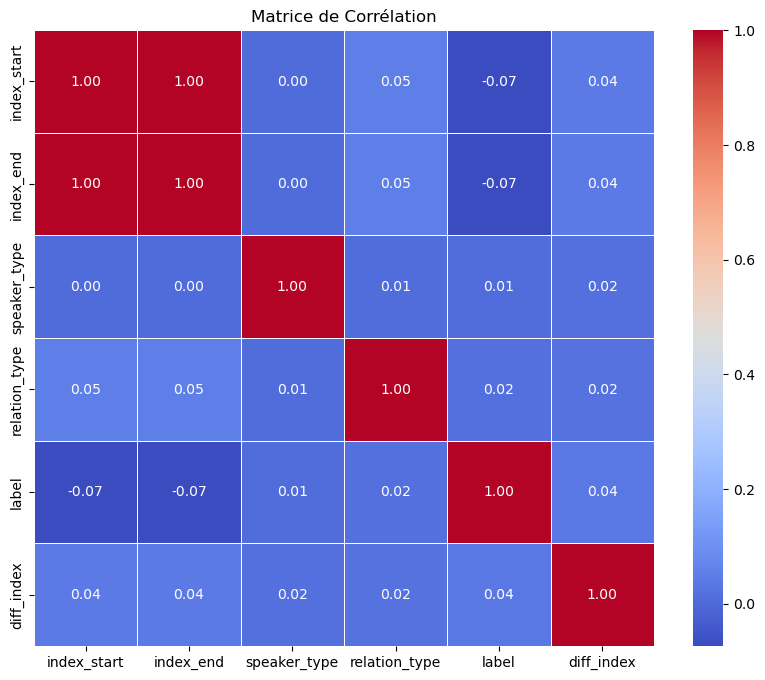

In [12]:
# Sélectionner les colonnes pour la matrice de corrélation
selected_columns = ['index_start', 'index_end', 'speaker_type', 'relation_type', 'label', 'diff_index']

# Créer un sous-dataframe avec les colonnes sélectionnées
corr_df = df[selected_columns]

# Calculer la matrice de corrélation
correlation_matrix = corr_df.corr()

# Tracer la matrice de corrélation colorée
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corrélation')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# Supprimer les colonnes non nécessaires de X_train (dialogue_id, index_start, index_end, etc.)
X = df.drop(['dialogue_id', 'label'], axis=1)

# Sélectionner la colonne 'label' comme y_train
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
y_train_ohe = to_categorical(y_train, num_classes=2)
y_test_ohe = to_categorical(y_test, num_classes=2)



2023-11-19 11:12:23.117314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout, Input

model = Sequential()
model.add(Input(389))
model.add(Dense(512, activation='relu'))  # Couche cachée avec 512 neurones
model.add(Dropout(0.5))  # Dropout pour la régularisation
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               199680    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 331522 (1.26 MB)
Trainable params: 331522 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
from tensorflow.keras import backend as K

# Définition de la fonction F1-score
def f1_score_keras(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return K.mean(f1)

# Utilisation de la fonction F1-score comme métrique
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_keras])


In [16]:
model.fit(X_train, y_train_ohe, epochs=3, batch_size=32, validation_split=0.2, validation_data=[X_test,y_test_ohe])


Epoch 1/3
1587/1587 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.7376 - f1_score_keras: 0.3569 - val_loss: nan - val_accuracy: 0.7589 - val_f1_score_keras: 0.0000e+00
Epoch 2/3
1587/1587 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.7550 - f1_score_keras: 0.0000e+00 - val_loss: nan - val_accuracy: 0.7589 - val_f1_score_keras: 0.0000e+00
Epoch 3/3
1587/1587 [==============================] - 6s 4ms/step - loss: nan - accuracy: 0.7550 - f1_score_keras: 0.0000e+00 - val_loss: nan - val_accuracy: 0.7589 - val_f1_score_keras: 0.0000e+00


In [17]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)

print(sum(y_pred_class))

680/680 [==============================] - 1s 2ms/step
0


In [18]:
from sklearn.metrics import f1_score

print("F1-score:", f1_score(y_test, y_pred_class))


F1-score: 0.0


In [19]:
test_pred = model.predict(df_test.drop(['dialogue_id'], axis=1))
test_labels = np.argmax(test_pred,axis=1)
print(test_labels)


969/969 [==============================] - 1s 1ms/step
[0 0 0 ... 0 0 0]


In [20]:
# Créer un dictionnaire pour stocker les prédictions
test_labels_final = {dialogue_id: [] for dialogue_id in dialogue_ids_test}

# Parcourir les lignes de df_test
for dialogue_id in dialogue_ids_test:
    # Obtenez les indices des lignes correspondant au dialogue_id
    indices = df_test[df_test['dialogue_id'] == dialogue_id].index
    print(df_test[df_test['dialogue_id'] == dialogue_id])
    # Ajouter les valeurs de test_label[index] au dictionnaire
    test_labels_final[dialogue_id] = test_labels[indices].tolist()


    dialogue_id  index_start  index_end  speaker_type  relation_type  \
0       ES2003a            0        1.0             0           12.0   
1       ES2003a            0        2.0             0           12.0   
2       ES2003a            2        3.0             0            6.0   
3       ES2003a            3        4.0             0            7.0   
4       ES2003a            4        5.0             0            7.0   
..          ...          ...        ...           ...            ...   
289     ES2003a          289      290.0             2           13.0   
290     ES2003a          290      291.0             0           13.0   
291     ES2003a          291      292.0             3            6.0   
292     ES2003a          289      293.0             2            6.0   
293     ES2003a          293      294.0             0           12.0   

      coord_0   coord_1   coord_2   coord_3   coord_4  ...  coord_375  \
0   -0.066844 -0.107671  0.001585 -0.037790 -0.075568  ...   0

In [21]:
with open("test_labels_text_mlp.json", "w") as file:
    json.dump(test_labels_final, file, indent=4)

#python make_submission.py --json_path Alice/test_labels_text_mlp.json